# Introduction

Before applying any fancy algorithms, the next step is to simply explore whether the processed corpuses and DTMs make sense.

When working with numerical data, some EDA techniques we can use include finding the mean, median or mode as well as the distribution of a data set. 

For text, we are going to find some more **obvious** patterns with EDA before identifying the hidden patterns with machines learning (ML) techniques. Relatively obious things are:

1. **Most common words** - find these and create word clouds
2. **Size of vocabulary** - look number of unique words

## Outline for EDA
1. With the DTM from the previous stage, sort into columns according to ascending order in value (of occurence)
2. Aggregate (or filter) data - select columns with the largest values.
3. Visualise top words - word clouds? bar charts?
4. Insights - a written comment/ description of the key takeaways.
5. Probably also try using TF-IDF (Term frequency - inverse data frequency) for better understanding the "uniqueness" or the "value" of the the vocabulary in the text.

# Most Common Words

Using the refined database from the previous data cleaning stage, we can now extract the most common words from all of the texts in the corpus. 

In [66]:
import pandas as pd
import pickle

bookNames = ['chocofact','fox','matilda']

data = pd.read_pickle("refined_dtm.pkl")
data

,say,mr,miss,matilda,honey,go,wonka,like,come,look,...,pad,murder,devising,lavatory,maggot,serpent,magician,messing,subtle,gasping
book_names,,,,,,,,,,,,,,,,,,,,,
chocofact,352,386,12,0,0,159,324,103,137,105,...,0,1,0,0,0,0,2,2,0,0
fox,152,132,2,0,0,39,0,23,32,31,...,0,0,0,0,0,0,0,0,0,0
matilda,589,70,453,430,382,155,0,163,114,122,...,2,1,2,2,2,2,0,0,2,2
sum,1093,588,467,430,382,353,324,289,283,258,...,2,2,2,2,2,2,2,2,2,2


We take note that there are currently 2394 words within the dataframe.

We are now going to tranpose it to reveal the top 10 words on the entire list. (Note that the data is already been sorted previously, so all I have to do is to mask the remaining entries.) 

In [67]:
data = data.transpose()
data.head(20)

book_names,chocofact,fox,matilda,sum
say,352,152,589,1093
mr,386,132,70,588
miss,12,2,453,467
matilda,0,0,430,430
honey,0,0,382,382
go,159,39,155,353
wonka,324,0,0,324
like,103,23,163,289
come,137,32,114,283
look,105,31,122,258


This is pretty unremarkable considering that words such as "say", "mr", "miss" etc. should be considered stop words. To mitigate this, I am going to remove words that have appeared more than 20 times in each of the 2 or more texts.

In [68]:
filtered_data = data
filtered_data = data[((data.chocofact <= 20) &  (data.fox <= 20)) | ((data.chocofact <= 20) &  (data.matilda <= 20)) | ((data.matilda <= 20) &  (data.fox <= 20))]

# Pickle this 
filtered_data.to_pickle("gross_top_dict.pkl")
filtered_data

book_names,chocofact,fox,matilda,sum
miss,12,2,453,467
matilda,0,0,430,430
honey,0,0,382,382
wonka,324,0,0,324
fox,0,245,0,245
...,...,...,...,...
serpent,0,0,2,2
magician,2,0,0,2
messing,2,0,0,2
subtle,0,0,2,2


Conversely, we can apply the opposite conditions to see what are the words that were removed in the process.

In [69]:
removed_data = data
removed_data = data[((data.chocofact > 20) &  (data.fox > 20)) | ((data.chocofact > 20) &  (data.matilda > 20)) | ((data.matilda > 20) &  (data.fox > 20))]
removed_data

book_names,chocofact,fox,matilda,sum
say,352,152,589,1093
mr,386,132,70,588
go,159,39,155,353
like,103,23,163,289
come,137,32,114,283
...,...,...,...,...
stare,32,6,21,59
give,22,8,25,55
moment,21,8,25,54
far,23,5,24,52


Luckily, the number of entries for `filtered_data` and `removed_data` does add up to 2394. We can now use this to plot a wordcloud for the 30 most common words within all the texts of the corpus.

To use the dataframe for the wordcloud, we have to work on several things:
1. Only keep the list of sum (remove columns corresponding individual texts)
2. Obtain the list of top 30 words, which means the dataframe must be transposed such that the keys can be accessed; and,
3. Obtain the list of sums
4. Using the 2 lists obtained in the 2 previous steps create pairs, which can be parsed into the word cloud generator.

In [70]:
wordcloud_dtm = filtered_data.head(30)
wordcloud_dtm = wordcloud_dtm.drop(bookNames, axis=1)
wordcloud_dtm

book_names,sum
miss,467
matilda,430
honey,382
wonka,324
fox,245
charlie,243
trunchbull,198
grandpa,159
chocolate,144
joe,126


In [71]:
# Obtain the frequencies
cloud_freq = wordcloud_dtm['sum'].to_list()
cloud_freq

[467,
 430,
 382,
 324,
 245,
 243,
 198,
 159,
 144,
 126,
 91,
 88,
 83,
 82,
 81,
 80,
 79,
 78,
 74,
 69,
 68,
 66,
 65,
 64,
 64,
 64,
 63,
 62,
 62,
 61]

In [72]:
# Obtain the list of words to be inserted into the word cloud.
wordcloud_dtm = wordcloud_dtm.transpose()
cloud_list = wordcloud_dtm.keys().to_list()
cloud_list

['miss',
 'matilda',
 'honey',
 'wonka',
 'fox',
 'charlie',
 'trunchbull',
 'grandpa',
 'chocolate',
 'joe',
 'teavee',
 'wormwood',
 'let',
 'bucket',
 'read',
 'factory',
 'school',
 'bean',
 'ticket',
 'book',
 'lift',
 'dear',
 'badger',
 'people',
 'oompa',
 'table',
 'golden',
 'feel',
 'run',
 'gloop']

In [73]:
pairs = []
for i in range(0,len(cloud_list)):
    pairs.append((cloud_list[i], int(cloud_freq[i])))

pairs

[('miss', 467),
 ('matilda', 430),
 ('honey', 382),
 ('wonka', 324),
 ('fox', 245),
 ('charlie', 243),
 ('trunchbull', 198),
 ('grandpa', 159),
 ('chocolate', 144),
 ('joe', 126),
 ('teavee', 91),
 ('wormwood', 88),
 ('let', 83),
 ('bucket', 82),
 ('read', 81),
 ('factory', 80),
 ('school', 79),
 ('bean', 78),
 ('ticket', 74),
 ('book', 69),
 ('lift', 68),
 ('dear', 66),
 ('badger', 65),
 ('people', 64),
 ('oompa', 64),
 ('table', 64),
 ('golden', 63),
 ('feel', 62),
 ('run', 62),
 ('gloop', 61)]

In [74]:
pairs_dict = dict((x, y) for x, y in pairs)
pairs_dict

{'miss': 467,
 'matilda': 430,
 'honey': 382,
 'wonka': 324,
 'fox': 245,
 'charlie': 243,
 'trunchbull': 198,
 'grandpa': 159,
 'chocolate': 144,
 'joe': 126,
 'teavee': 91,
 'wormwood': 88,
 'let': 83,
 'bucket': 82,
 'read': 81,
 'factory': 80,
 'school': 79,
 'bean': 78,
 'ticket': 74,
 'book': 69,
 'lift': 68,
 'dear': 66,
 'badger': 65,
 'people': 64,
 'oompa': 64,
 'table': 64,
 'golden': 63,
 'feel': 62,
 'run': 62,
 'gloop': 61}

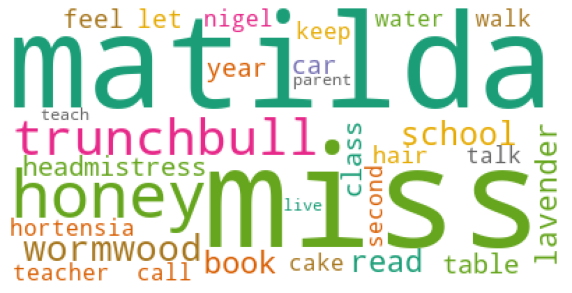

In [83]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = [10, 10]

image_mask = np.array(Image.open('fox.png'))
wc = WordCloud(background_color="white", colormap="Dark2", random_state=42) # mask = image_mask)

wc.fit_words(pairs_dict)
plt.imshow(wc)
plt.axis("off")
plt.show()

## Word Clouds for individual texts
However, as we can see, since the themes covered within the texts are quite dynamic, the word cloud can't really point to a specific theme. A better idea would be to create individual word cloud for each text. Hence, the entire process is repeated for each text. To begin, we start with the `filtered_data` dataframe that we have created earlier:

In [76]:
full_filtered_data = filtered_data.drop("sum", axis=1)
full_filtered_data

book_names,chocofact,fox,matilda
miss,12,2,453
matilda,0,0,430
honey,0,0,382
wonka,324,0,0
fox,0,245,0
...,...,...,...
serpent,0,0,2
magician,2,0,0
messing,2,0,0
subtle,0,0,2


In [77]:
# Find the top 30 words in each text, and return as a list of list of pairs.
top_dict = {}
for c in full_filtered_data.columns:
    top = full_filtered_data[c].sort_values(ascending=False).head(30) # want to be descending (large to small), so not ascending.
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{'chocofact': [('wonka', 324),
  ('charlie', 243),
  ('grandpa', 159),
  ('chocolate', 134),
  ('joe', 126),
  ('teavee', 91),
  ('factory', 79),
  ('bucket', 76),
  ('ticket', 73),
  ('oompa', 64),
  ('gloop', 61),
  ('loompa', 60),
  ('golden', 55),
  ('salt', 53),
  ('gum', 53),
  ('bar', 51),
  ('chew', 49),
  ('lift', 48),
  ('mike', 46),
  ('dear', 44),
  ('people', 44),
  ('veruca', 44),
  ('augustus', 44),
  ('television', 41),
  ('beauregarde', 41),
  ('violet', 41),
  ('grandma', 40),
  ('bed', 37),
  ('sweet', 32),
  ('river', 32)],
 'fox': [('fox', 245),
  ('badger', 65),
  ('bean', 64),
  ('bunce', 50),
  ('hole', 42),
  ('dig', 38),
  ('tunnel', 32),
  ('chicken', 29),
  ('cider', 26),
  ('boggis', 24),
  ('jar', 21),
  ('dad', 21),
  ('boggi', 21),
  ('let', 18),
  ('wait', 18),
  ('rat', 17),
  ('night', 16),
  ('soon', 16),
  ('food', 15),
  ('run', 15),
  ('hill', 14),
  ('shall', 13),
  ('duck', 13),
  ('farm', 13),
  ('feast', 12),
  ('big', 12),
  ('shovel', 12),
 

In [78]:
# Print the 30 words neatly.

for text, top_words in top_dict.items():
    print(text, ":")
    print(', '.join([word for word, count in top_words[0:29]]))
    print('---')

chocofact :
wonka, charlie, grandpa, chocolate, joe, teavee, factory, bucket, ticket, oompa, gloop, loompa, golden, salt, gum, bar, chew, lift, mike, dear, people, veruca, augustus, television, beauregarde, violet, grandma, bed, sweet
---
fox :
fox, badger, bean, bunce, hole, dig, tunnel, chicken, cider, boggis, jar, dad, boggi, let, wait, rat, night, soon, food, run, hill, shall, duck, farm, feast, big, shovel, wall, fat
---
matilda :
miss, matilda, honey, trunchbull, wormwood, school, book, read, lavender, headmistress, class, table, let, feel, car, year, hair, water, call, talk, teacher, cake, walk, hortensia, second, nigel, keep, parent, teach
---


As far as concerned, we don't really see any top words that exist in multiple texts, which means that the stop words removal during the data cleaning stage worked quite well indeed! 

Let's pickle this and generate the word clouds.

In [79]:
with open("dahl_top_dict.pkl", "wb") as file:
    pickle.dump(top_dict, file)

In [80]:
# Test obtaining a dictionary from a story.
fox_pairs = top_dict["fox"]
pairs_dict = dict((x, y) for x, y in fox_pairs)
pairs_dict

{'fox': 245,
 'badger': 65,
 'bean': 64,
 'bunce': 50,
 'hole': 42,
 'dig': 38,
 'tunnel': 32,
 'chicken': 29,
 'cider': 26,
 'boggis': 24,
 'jar': 21,
 'dad': 21,
 'boggi': 21,
 'let': 18,
 'wait': 18,
 'rat': 17,
 'night': 16,
 'soon': 16,
 'food': 15,
 'run': 15,
 'hill': 14,
 'shall': 13,
 'duck': 13,
 'farm': 13,
 'feast': 12,
 'big': 12,
 'shovel': 12,
 'wall': 12,
 'fat': 12,
 'gun': 12}

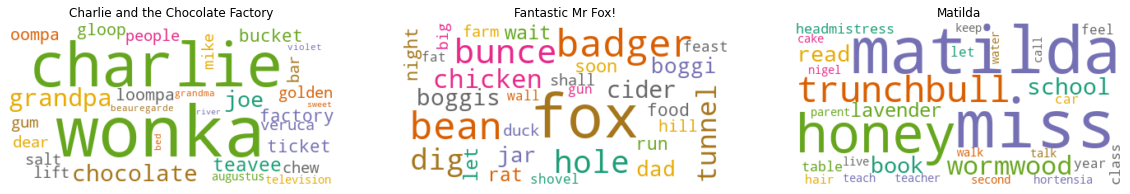

In [81]:
# Reset the output dimensions
plt.rcParams['figure.figsize'] = [20, 20]

fullNames = [
    'Charlie and the Chocolate Factory',
    'Fantastic Mr Fox!',
    'Matilda'
]

# Create subplots for each comedian
for index, storyName in enumerate(full_filtered_data.columns):

    dahl_pairs = top_dict[storyName]
    pairs_dict = dict((x, y) for x, y in dahl_pairs)

    wc.fit_words(pairs_dict)
    
    plt.subplot(2, 3, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(fullNames[index])
    
plt.show()